In [ ]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv("/content/historical_data.csv")

In [25]:
df.head()

1.0

In [4]:
df.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

In [5]:
store_id_unique = df["store_id"].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode()
                         for store_id in store_id_unique}
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
# fill null values
df["store_primary_category"] = df.store_id.apply(fill)
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,indian,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,indian,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,indian,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,indian,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [6]:
df['total_order_time'] = (pd.to_datetime(df['actual_delivery_time']) - pd.to_datetime(df['created_at'])).dt.total_seconds()
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_order_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,indian,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,indian,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,indian,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,indian,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [7]:
df = df[df['total_order_time'] < 86400] # the equivalent of an entire day

## One-Hot Encoding

In [8]:
df.dropna(inplace=True)
# df.drop(columns=['store_id'], inplace=True)
# df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

df_encoded = pd.get_dummies(df, columns=['market_id', 'store_primary_category', 'order_protocol'])

# Scaling

In [9]:

# train test split
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)

y_train = train_df["total_order_time"] # same thing for training data
X_train = train_df.drop(["total_order_time"], axis = 1)

y_test = test_df["total_order_time"] # set our output equal to the median house value column
X_test = test_df.drop(["total_order_time"], axis = 1) # remove that column from the input. axis = 1 means to remove the column

In [10]:
# Scaling to be done on numerical features
numerical_columns = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration']
len(X_train)

142825

In [11]:
# Scale only the numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

## K-Means Clustering

In [ ]:
# Initialize K-means with the desired number of clusters
num_clusters = 5  # Replace this with your desired number of clusters
kmeans = KMeans(n_clusters=num_clusters)

# Fit K-means to your data
kmeans.fit(X_train)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to your dataset or perform further analysis
X_train['Cluster'] = cluster_labels

# View the clusters
print(X_train['Cluster'].value_counts())

## DBSCAN

In [ ]:
dbscan = DBSCAN(eps=1.7, min_samples=5)  # Adjust parameters as needed

# Fit DBSCAN to the scaled data
dbscan.fit(X_train)

# Get cluster labels
cluster_labels = dbscan.labels_

# Analyze the results
# For example, count the number of clusters and outliers
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_ = list(cluster_labels).count(-1)

print(f'Number of clusters: {n_clusters_}')
print(f'Number of noise points: {n_noise_}')

Number of clusters: 28
Number of noise points: 7403


## Prediction

In [ ]:
X_DB = X_train
X_DB['Clusters'] = cluster_labels
DB = X_DB
DB['total_order_time'] = y_train
# Group by 'clusters' column and calculate the mean of 'total_order_time' for each cluster
cluster_means = DB.groupby('Clusters')['total_order_time'].mean().reset_index()

# Rename the columns for clarity (if needed)
cluster_means = cluster_means.rename(columns={'total_order_time': 'Mean_Total_Order_Time'})

DB = DB.merge(cluster_means, on='Clusters', how='left')
DB.head()


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,Clusters,total_order_time,Mean_Total_Order_Time
0,-0.443743,-1.057910,-0.414960,-0.805581,-1.175297,1.620653,1.525089,1.568642,-0.639346,-0.795838,...,0,0,0,1,0,0,0,0,3045.0,2761.372689
1,0.658950,0.546859,0.814575,-0.357970,0.067074,2.314951,2.581353,1.985840,-0.639346,0.086602,...,0,0,1,0,0,0,0,0,2279.0,2761.372689
2,0.658950,1.152070,1.429342,0.026515,-0.108884,0.463489,0.406692,0.165338,-0.639346,-0.023131,...,0,0,0,0,1,0,0,0,2589.0,2761.372689
3,-0.811308,-1.061196,-1.029727,0.139374,-0.714962,-0.520101,-0.494240,-0.194969,1.524334,-0.077998,...,1,0,0,0,0,0,0,1,4267.0,3010.582050
4,-0.443743,-0.682734,-0.414960,-0.786452,-0.064450,-0.635817,-0.742773,-0.915584,-0.639346,-1.339933,...,0,0,1,0,0,0,0,0,906.0,2761.372689


## Root Mean Squared Error

In [ ]:
rmse = np.sqrt(((DB['total_order_time'] - DB['Mean_Total_Order_Time']) ** 2).mean())
rmse

1145.2330994448823

In [ ]:
df_encoded.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_primary_category_vietnamese,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,Clusters,total_order_time
92430,-0.443743,-1.057910,-0.414960,-0.805581,-1.175297,1.620653,1.525089,1.568642,-0.639346,-0.795838,...,0,0,0,0,1,0,0,0,0,3045.0
100843,0.658950,0.546859,0.814575,-0.357970,0.067074,2.314951,2.581353,1.985840,-0.639346,0.086602,...,0,0,0,1,0,0,0,0,0,2279.0
180890,0.658950,1.152070,1.429342,0.026515,-0.108884,0.463489,0.406692,0.165338,-0.639346,-0.023131,...,0,0,0,0,0,1,0,0,0,2589.0
12800,-0.811308,-1.061196,-1.029727,0.139374,-0.714962,-0.520101,-0.494240,-0.194969,1.524334,-0.077998,...,0,1,0,0,0,0,0,0,1,4267.0
119146,-0.443743,-0.682734,-0.414960,-0.786452,-0.064450,-0.635817,-0.742773,-0.915584,-0.639346,-1.339933,...,0,0,0,1,0,0,0,0,0,906.0


In [ ]:
# Define the XGBoost regressor
regressor = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators=100,
                             seed=42,
                             gamma=0.25,
                             learn_rate=0.1,
                             max_depth=4,
                             reg_lambda=10,
                             scale_pos_wegiht=3,
                             subsample=0.9,
                             colsample_bytree=0.5)

In [ ]:
# Train the model
regressor.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:03:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "learn_rate", "scale_pos_wegiht" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.25, grow_policy=None, importance_type=None,
             interaction_constraints=None, learn_rate=0.1, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1037523.8053978183


weight:  {'total_items': 30.0, 'subtotal': 66.0, 'num_distinct_items': 41.0, 'min_item_price': 72.0, 'max_item_price': 108.0, 'total_onshift_dashers': 202.0, 'total_busy_dashers': 164.0, 'total_outstanding_orders': 225.0, 'estimated_order_place_duration': 24.0, 'estimated_store_to_consumer_driving_duration': 124.0, 'market_id_1.0': 37.0, 'market_id_2.0': 22.0, 'market_id_3.0': 20.0, 'market_id_4.0': 16.0, 'market_id_5.0': 24.0, 'market_id_6.0': 1.0, 'store_primary_category_afghan': 8.0, 'store_primary_category_alcohol': 4.0, 'store_primary_category_american': 6.0, 'store_primary_category_asian': 1.0, 'store_primary_category_barbecue': 5.0, 'store_primary_category_brazilian': 4.0, 'store_primary_category_breakfast': 7.0, 'store_primary_category_bubble-tea': 4.0, 'store_primary_category_burger': 2.0, 'store_primary_category_burmese': 2.0, 'store_primary_category_cafe': 3.0, 'store_primary_category_caribbean': 2.0, 'store_primary_category_chinese': 9.0, 'store_primary_category_convenience

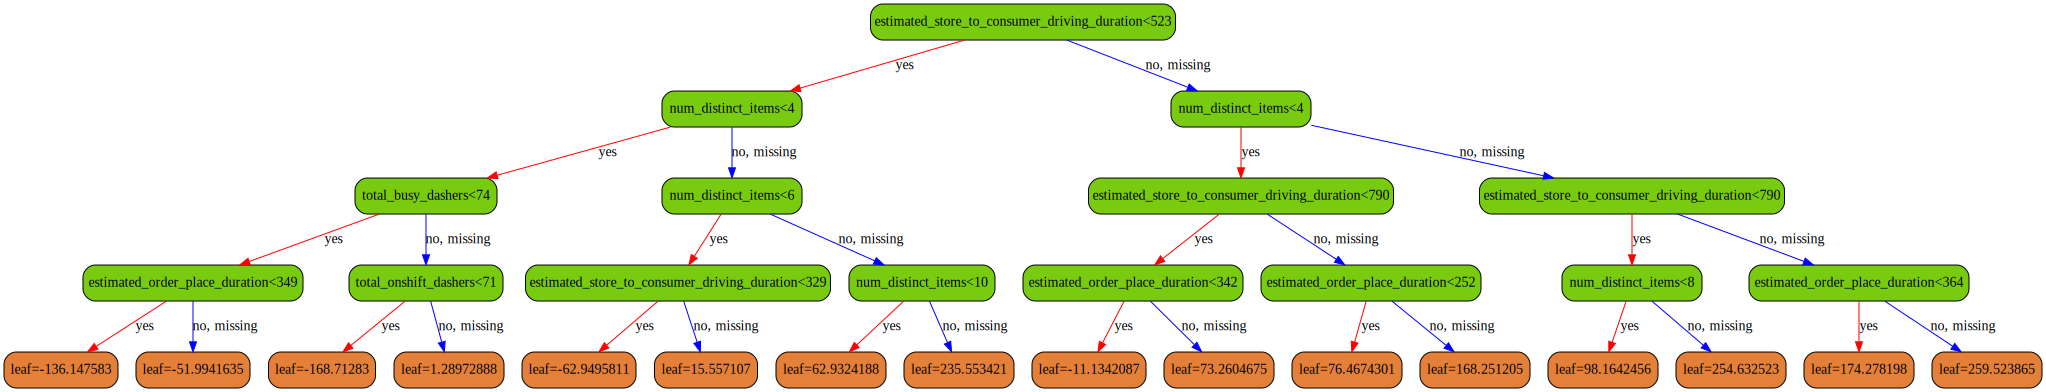

In [ ]:
bst = regressor.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
  print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape' : 'box',
               'style' : 'filled, rounded',
               'fillcolor' : '#78cbe'}
leaf_params = {'shape' : 'box',
               'style' : 'filled, rounded',
               'fillcolor' : '#e48038'}
xgb.to_graphviz(regressor, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

Ensmble

In [ ]:
def getEuclideanDistance(row1, row2):
  euclidean_distance = np.linalg.norm(row1 - row2)

In [ ]:
#HyperParameter as d distance
d = 4

x = df[(df['market_id']==1.0) & (df['subtotal'] == 3441)]['market_id']
def predictWithEnsemble(X):
  for cluster in cluster_labels:
    if getEuclideanDistance(cluster_means[cluster_means['Clusters'] == cluster][0], X) < d:
      return cluster_means['Mean_Order_Time']
  return regressor.predict(X)